In [39]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad
from matplotlib import colors
import uproot
from EBL_fit_MC_functions import *

In [40]:
fit_func_name = "PWL" # Function to fit. Possible options "MBPWL" (concave multiply broken power-law), "PWL" (Power-law), "LP" (concave Log-Parabola), "freeLP (Log-Parabola without concavity constraint)#Maybie more will be added in the future
Telescope = "MAGIC" # Telescope to simulate. Possible options: "CTA_alpha", "MAGIC" (MAGIC does not work propperly yet)
Spectrum_func_name = "PWL" #Function for the simulated spectrum. POssible options: "PWL" , "LP" will be added soon but its not yet implemented.
EBL_Model = "Dominguez" #EBL model to test. Only "Dominguez" (Domínguez et al. 2011) is available at the moment.
Source_flux = 8.7e-6#8.70e-6 # f0 flux of the source. Should be in m−2  s−1  TeV−1
Observation_time = 42480 #Observation time in seconds
niter = 1000 #number of iterations for the chi^2 vs alpha plot #The niter=1 has a different plot (just give it a try)
Energy_migration = True #True #True if you want to do the Energy migration or False if you don't want to.

#for the chi² vs alpha plot:
initial_guess_pos = 1.5 #recommended values for MBPWL (>1.), for LP (<1.) (the chi² for alpha=initial_guess_pos if much worse than the other ones, will be fixed soon), for PWL (>1.)
step = 0.05
last_bin = 2.
first_bin = 0.

#for PWL Spectrum function
if Spectrum_func_name == "PWL":
    Norm = 0.25 #Normalization Energy in TeV (Default 0.25)
    Ph_index = 2.03 #photon index for the power law (Default 2.03)

#for MBPWL as fit_function
if fit_func_name == "MBPWL":
    knots = 3 #Number of knots of the function. 3 is the default.
    initial_guess_0 = np.array([5e-7, 0, 0, 0, 0]) #initial guess of the MBPWL parameters: phi_0, lam1, deltas (len(deltas)=knots-2))

    Efirst = 0.2 #Energy of the first knot
    Elast = 1.1 #Energy of the last knot
    #the rest of the bins are distributed logaritmically between those two values

#for PWL
elif fit_func_name == "PWL":
    initial_guess_0 = np.array([5e-7, 2.]) #phi_0, gamma
#for LP and freeLP
elif fit_func_name == "LP" or fit_func_name == "freeLP":
    initial_guess_0 = np.array([5e-7, 2., 1.]) #phi_0, alpha, beta

Now we define the Multiple broken power law

In [41]:
if fit_func_name != "MBPWL":
    knots = 0
    Efirst = 0
    Elast = 0
fit_func = fit_func_select(fit_func_name, knots, Efirst, Elast)
# if fit_func_name == "MBPWL":
#     def fit_func(xdata, params):
#         if knots < 2 or knots > 30: #change this when adding more number of knots
#             raise Exception('knots have to be larger or equal than 3 and smaller than 30')
#         else:
#             polw = np.zeros(len(xdata))
#             Ebr = np.geomspace(xdata[0], xdata[-1], knots+2)[1:-1]
#             gamma = np.zeros(knots+1)
#             phi = np.zeros(knots+1)
#             phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
#             gamma0 = params[1]
#             sqrtdelta_gamma = params[2:knots+2]
#             delta_gamma = np.square(sqrtdelta_gamma)
#             gamma[0] = gamma0
#             phi[0] = phi_0
#             for i in range(knots):
#                 gamma[i+1] = gamma[i] + delta_gamma[i]
#                 phi[i+1] = phi[i] * Ebr[i] ** delta_gamma[i]
#             for i in range(len(xdata)):
#                 for j in range(knots):
#                     if xdata[i]<Ebr[0]:
#                         polw[i] = phi[0] * xdata[i] ** (-gamma[0])
#                     elif Ebr[-1] < xdata[i]:
#                         polw[i] = phi[-1] * xdata[i] ** (-gamma[-1])
#                     elif Ebr[j] <= xdata[i] < Ebr[j+1]:
#                         polw[i] = phi[j+1] * xdata[i] ** (-gamma[j+1])
#         return polw

# elif fit_func_name == "PWL":
#     def fit_func(xdata, params):
#         phi = params[0]
#         gamma = params [1]
#         PLW = phi * xdata ** (-gamma)
#         return PLW

# elif fit_func_name == "LP":
#     def fit_func(xdata, params):
#         phi0 = params[0]
#         alpha = params[1]
#         beta = params[2]
#         #Enorm = 1TeV #if it is 1 TeV no need ot include it (if it is different, need to add it to te LP function)
#         LP = phi0 * (xdata) ** (alpha - beta * beta * np.log(xdata))
#         return LP

# elif fit_func_name == "freeLP":
#     def fit_func(xdata, params):
#         phi0 = params[0]
#         alpha = params[1]
#         beta = params[2]
#         #Enorm = 1TeV #if it is 1 TeV no need ot include it (if it is different, need to add it to te LP function)
#         LP = phi0 * (xdata) ** (alpha - beta * np.log(xdata))
#         return LP


# else:
#     raise Exception('The function "{func}" has not been implemented.'.format(func = fit_func_name))


#Can't put this two functions in the EBL_fit_MC_functions.py as LSQ needs 2 global parameters which I cannot introduce in the .py.
def LSQ(params):
    return np.sum((ydata - fit_func(xdata, params)) ** 2 / ydata_u ** 2)

def fit(initial_guess):
    #print('Warning: the shape of the parametes will depend on the number of knots (defined as knots)')
    #print('Warning: this will give the parameters of the fit and its errors which have to be put into the multiple_bpl function in order to get the fit')
    LSQ.errordef = Minuit.LIKELIHOOD

    m = Minuit(LSQ, initial_guess)
    #m.limits["initial_guess[2:-1]"] = (0,None)
    m.tol = 1e-20

    m.migrad()
    # print(m.values)

    #m.hesse()
    # print(m.errors)

    return m

Here we will load the Effective area of the telescope and the EBL model file. After that we will also load background rate.

In [42]:
fileEA = np.loadtxt('EffAreaMAGIC.txt', skiprows = 3)
EffA = pd.DataFrame(fileEA)
EffA = EffA.rename(columns={ 0 : 'E [TeV]', 1: 'Eff area (m^2)'})
EffaE= EffA['E [TeV]'].to_numpy() #we will use Etruecenter for this value so you can comment it if u want
Effa = EffA['Eff area (m^2)'].to_numpy()

#absorption file
file = np.loadtxt('tau_dominguez11.out')
pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})
E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()

We now load the background and migration matrix with uproot

In [43]:
Bckg = uproot.open("Output_flute.root:hEstBckgE")
Bckgval = Bckg.values()
Eestedges = Bckg.axis("x").edges()/1e3
Eestcenters = Bckg.axis("x").centers()/1e3

migrmatrix = uproot.open("Output_flute.root:migrmatrix")

migmat = migrmatrix.values()[:,:,0]
#edgesx = migrmatrix.axis("x").edges() #we don't need this as it is the same as edgesEest
Etrueedges = migrmatrix.axis("y").edges() #Etrue
Etruemin = Etrueedges[:-1]/1e3
Etruemax = Etrueedges[1:]/1e3
Etruecenter = (migrmatrix.axis("y").centers()/1e3)[:]
Etruebinw = Etruemax-Etruemin

After that we create the spectrum of the source and we absorve it with the EBL model loaded before. If you want to change the source spectra, change it here.

In [44]:
#“photon index  = 2.03  +/- 0.03 and normalization factor at 250 GeV    f0 = (8.70 +/- 0.17) * 10^-10 cm^-2  s^-1  TeV^-1.”
K =  8.70e-6#8.70e-6 #m−2  s−1  TeV−1
dNdE = K / ((E/0.25)**2.03) 
m_tau = -tau
dNdEa = (dNdE * np.exp(m_tau))

We will now rebin the spectrum to the bins of the energy resolution.

In [45]:
# tau_rebin = interpolate.interp1d(np.log10(E), np.log10(tau), bounds_error=False, fill_value=0)
# tau_reb = 10 ** (tau_rebin(np.log10(Etruecenter)))
# tau_reb2 = 10 ** (tau_rebin(np.log10(Eestcenters)))

tau_reb = log_interp1d(E, tau, Etruecenter)
tau_reb2 = log_interp1d(E, tau, Eestcenters)

dNdE = K / ((Etruecenter/0.25)**2.03) 
m_tau = -tau_reb
dNdEareb = (dNdE * np.exp(m_tau))


# dNdEafunc = interpolate.interp1d(np.log10(E), np.log10(dNdEa),bounds_error=False, fill_value=0)
# dNdEareb = 10** (dNdEafunc(np.log10(Etruecenter)))

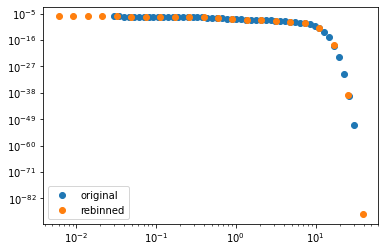

In [46]:
plt.plot(E, E*E*dNdEa, "o", label="original")
plt.plot(Etruecenter, Etruecenter*Etruecenter*dNdEareb, "o", label = "rebinned")
plt.xscale("log")
plt.yscale("log")
plt.legend()
#plt.xlim(np.min(E), 4)
#plt.ylim(1e-9, 1e-6)
plt.show()

We use all that and we define the time of observation and we have the poisson parameter of the background.

In [47]:
time = 42652 #42480 #180000#s
bckgmu = Bckgval

Ebinsmin = Eestedges[:-1]
Ebinsmax = Eestedges[1:]
Ebinscent = Eestcenters
Ebinsw = Ebinsmax - Ebinsmin


# Effafunc = interpolate.interp1d(np.log10(EffaE), np.log10(Effa), bounds_error=False, fill_value=0)
# Effareb = 10 ** (Effafunc(np.log10(Ebinscent)))
Effareb = log_interp1d(EffaE, Effa, Ebinscent)

# plt.plot(Ebinsmin, np.ones(len(Ebinsmin)), "o", label="Emin")
# plt.plot(Ebinsmax, np.ones(len(Ebinsmax))/2, "o", label="Emax")
# for i in range(len(Ebinscent)):
#     plt.axvline(Ebinscent[i])
# plt.legend()
# plt.xscale("log")

In [48]:
Effa2 = Effa
for i in range(3):
    Effa2 = np.insert(Effa2, 0, 0.)
Effa2 = np.append(Effa2, 0.)

Let's get the poisson parameter of the source taking into account the energy resolution.

migrmatrix->Project3D("yx")->Draw("zcol")


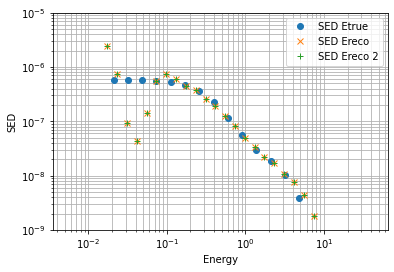

In [49]:
mu_vec = dNdEareb * Effa2 * Etruebinw * time
#migmat[Ecenterspos, Etruecenterspos]
if Energy_migration:
    mu_vec_reco = np.zeros(len(Ebinscent))
    for i in range(len(Ebinscent)):
        mu_vec_reco[i] = np.sum(mu_vec * migmat[i])
    mu_vec_recotest = []
    for i in range(len(mu_vec)):
        testing = mu_vec[i] * migmat[:,i]
        mu_vec_recotest.append(testing)
    mu_vec_reco2 = np.sum(mu_vec_recotest, axis = 0)
else:
    mu_vec_reco = log_interp1d(Etruecenter[3:-1], dNdEareb[3:-1], Eestcenters) * Effareb * Ebinsw * time


# mu_vec_reco = np.zeros(len(mu_vec))
plt.plot(Etruecenter[3:-1], np.square(Etruecenter[3:-1]) * mu_vec[3:-1] / (Effa2[3:-1] * Etruebinw[3:-1] * time), "o", label="SED Etrue")
#plt.plot(Ebinscent[10:-7], np.square(Ebinscent[10:-7])*mu_vec_reco[10:-7] / (Effareb[10:-7] * Ebinsw[10:-7] * time), 'o', label= "SED Ereco")
plt.plot(Ebinscent, np.square(Ebinscent)*mu_vec_reco / (Effareb * Ebinsw * time), 'x', label= "SED Ereco")
plt.plot(Ebinscent, np.square(Ebinscent)*mu_vec_reco2 / (Effareb * Ebinsw * time), '+', label= "SED Ereco 2")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy")
plt.ylabel("SED")
plt.legend()
plt.ylim(1e-09,1e-05)
plt.grid(which="both")
plt.show()

# print(mu_vec)
# print(migmat[15])
# print(mu_vec_reco[15])
# migmatsum = np.zeros(len(Ebinscent))
# for i in range(len(Ebinscent)):
#     migmatsum[i] = np.sum(migmat[i])

# plt.plot(Ebinscent, migmatsum)
# plt.xscale("log")

# migmatsum2 = np.sum(migmat, axis = 1)

# plt.plot(Ebinscent, migmatsum2[:len(Ebinscent)], "o")
# plt.xscale("log")

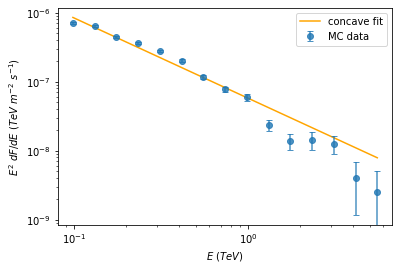

In [50]:
my_generator = np.random.default_rng(2021)
Simbckg1 = my_generator.poisson(bckgmu)
# Simbckg1 = Simbckg1.astype(float)
# for i in range(len(Simbckg1)):
#     if Simbckg1[i] == 0:
#         Simbckg1[i] = bckgmu[i]
Simbckg1_u = np.sqrt(Simbckg1)
Simbckg5 = my_generator.poisson(5*bckgmu)/5
# Simbckg5 = Simbckg5.astype(float)
# for i in range(len(Simbckg5)):
#     if Simbckg5[i] == 0:
#         Simbckg5[i] = bckgmu[i]
Simbckg5_u = np.sqrt(Simbckg5)

N = my_generator.poisson(mu_vec_reco)
for i in range(len(N)):
    if N[i] == 0:
        N[i] = 1
N_u = np.sqrt(N)

NpB = N + Simbckg1 - Simbckg5
NpB_u = N_u + Simbckg1_u - Simbckg5_u
for i in range(len(NpB)):
    if NpB[i] == 0:
        NpB[i] = 1
    if NpB_u[i] == 0:
        NpB_u[i] = 1

dNdE_b = NpB[10:-7] / Effareb[10:-7] / Ebinsw[10:-7] / time  #not strictly correct after energy migration
dNdE_b_u = NpB_u[10:-7] / Effareb[10:-7] / Ebinsw[10:-7] / time

SED = np.square(Ebinscent[10:-7]) * dNdE_b
SED_u = np.square(Ebinscent[10:-7]) * dNdE_b_u

# plt.errorbar(Ebinscent[10:-7], SED, label='MC data',yerr = SED_u, capsize=3, fmt='o', alpha=0.8)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel(r"$E$ ($TeV$)")
# plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
# plt.legend()
# plt.show()

ydata = SED
xdata = Ebinscent[10:-7]
knots = 3
ydata_u = SED_u
initial_guess = np.array([5e-7, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
things = fit(initial_guess=initial_guess)

Egam = np.geomspace(Ebinscent[10], Ebinscent[-8], 300)

plt.plot(Egam, fit_func(Egam, things.values), label='concave fit', color = 'orange')
plt.errorbar(xdata, ydata, label='MC data',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$E$ ($TeV$)")
plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
plt.legend()
plt.show()

We finally run our simulation. First we generate 2 random samples of the background. The first one is the background contribution to the observations and the other one is the observed background in 5 wobbles that we will use to reduce the background noise. After that we also simulate the source spectra. Those 3 things are made using a Poisson disteibution. Then we sum the 3 contributions and we take the number of photons to SED. Finally we use this SED and deabsorb the EBL while fitting the MBPWL to every value of $\alpha$ and get its corresponding $\chi^2$ value.

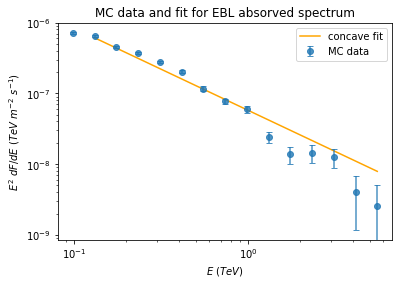

 iteration 1 of 1000 finished 
 iteration 2 of 1000 finished 
 iteration 3 of 1000 finished 
 iteration 4 of 1000 finished 
 iteration 5 of 1000 finished 
 iteration 6 of 1000 finished 
 iteration 7 of 1000 finished 
 iteration 8 of 1000 finished 
 iteration 9 of 1000 finished 
 iteration 10 of 1000 finished 
 iteration 11 of 1000 finished 
 iteration 12 of 1000 finished 
 iteration 13 of 1000 finished 
 iteration 14 of 1000 finished 
 iteration 15 of 1000 finished 
 iteration 16 of 1000 finished 
 iteration 17 of 1000 finished 
 iteration 18 of 1000 finished 
 iteration 19 of 1000 finished 
 iteration 20 of 1000 finished 
 iteration 21 of 1000 finished 
 iteration 22 of 1000 finished 
 iteration 23 of 1000 finished 
 iteration 24 of 1000 finished 
 iteration 25 of 1000 finished 
 iteration 26 of 1000 finished 
 iteration 27 of 1000 finished 
 iteration 28 of 1000 finished 
 iteration 29 of 1000 finished 
 iteration 30 of 1000 finished 
 iteration 31 of 1000 finished 
 iteration 32 of 

In [51]:
bckgmu_final = bckgmu[10:-7]
mu_vec_final = mu_vec_reco[10:-7]
E_final = Ebinscent[10:-7]
Effa_final = Effareb[10:-7]
Ebinsw_final = Ebinsw[10:-7]
tau = tau_reb2[10:-7]
xdata = E_final

things = fit(initial_guess = initial_guess_0)

Egam = np.geomspace(E_final[1],E_final[-1], 300)

plt.plot(Egam, fit_func(Egam, things.values), label='concave fit', color = 'orange')
plt.errorbar(xdata, ydata, label='MC data',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
plt.title("MC data and fit for EBL absorved spectrum")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$E$ ($TeV$)")
plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
plt.legend()
plt.show()

chisqs_iter = []
alphas_iter = []

for j in range(niter):
    SED, SED_u, dNdE_b, dNdE_b_u = SED_gen(j, bckgmu_final, mu_vec_final, Effa_final, Ebinsw_final, Observation_time, E_final)
    chisqs = []
    alphas = alphas_creation(initial_guess_pos, first_bin, last_bin, step)
    ydata, ydata_u = SED_alpha(initial_guess_pos, dNdE_b, dNdE_b_u, tau, E_final)
    things = fit(initial_guess=initial_guess_0)
    initial_guess_mat = ig_mat_create(fit_func_name, alphas, knots)
    initial_guess_mat[0] = things.values

    for i, alpha in enumerate(alphas):
        ydata, ydata_u = SED_alpha(alpha, dNdE_b, dNdE_b_u, tau, E_final)
        initial_guess = initial_guess_mat[i] #phi_0, lam1, deltas (len(deltas)=knots))
        if alpha == initial_guess_pos:
            initial_guess = initial_guess_mat[0]
        things = fit(initial_guess=initial_guess)
        if i < (len(alphas)):
            initial_guess_mat[i+1] = things.values
        chi2 = chisq(ydata, fit_func(E_final, things.values), ydata_u)
        chisqs.append(chi2)
        # if alpha == 1.5 and j == 1:# or alpha == 0.15 or alpha == 0.9 or alpha == 1.:
        #     print(chi2)
        #     plt.plot(xdata, multiple_bpl(xdata, things.values), label='concave fit', color = 'orange')
        #     plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
        #     plt.xscale('log')
        #     plt.yscale('log')
        #     plt.xlabel(r"$E$ ($TeV$)")
        #     plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
        #     plt.legend()
        #     plt.show() 

    alphas_iter.append(alphas)
    chisqs_iter.append(chisqs)
    print("\033[2;31;43m iteration {iter} of {niter} finished \033[0;0m".format(iter = j+1, niter = niter))
# niter = 1000 #number of iterations (1000 iterations take ~19 min)
# chisqs_iter = []
# alphas_iter = []
# initial_guess_pos = 1.
# step = 0.05
# last_bin = 2.
# first_bin = 0.
# knots = 3

# for j in range(niter):
#     my_generator = np.random.default_rng(j)
#     Simbckg1 = my_generator.poisson(bckgmu)
#     # Simbckg1 = Simbckg1.astype(float)
#     # for i in range(len(Simbckg1)):
#     #     if Simbckg1[i] == 0:
#     #         Simbckg1[i] = bckgmu[i]
#     Simbckg1_u = np.sqrt(Simbckg1)
#     Simbckg5 = my_generator.poisson(5*bckgmu)/5
#     # Simbckg5 = Simbckg5.astype(float)
#     # for i in range(len(Simbckg5)):
#     #     if Simbckg5[i] == 0:
#     #         Simbckg5[i] = bckgmu[i]
#     Simbckg5_u = np.sqrt(Simbckg5)

#     N = my_generator.poisson(mu_vec_reco)

#     for i in range(len(N)): #this is used to avoid crashing when dividing by 0.
#         if N[i] == 0:
#             N[i] = 1
#     N_u = np.sqrt(N)

#     NpB = np.around(N + Simbckg1 - Simbckg5).astype(int)
#     NpB_u = N_u + Simbckg1_u - Simbckg5_u
#     for i in range(len(NpB)):
#         if NpB[i] == 0:
#             NpB[i] = 1
#         if NpB_u[i] == 0:
#             NpB_u[i] = 1


#     dNdE_b = NpB[10:-7] / Effareb[10:-7] / Ebinsw[10:-7] / time  #not strictly correct after energy migration
#     dNdE_b_u = NpB_u[10:-7] / Effareb[10:-7] / Ebinsw[10:-7] / time

#     SED = np.square(Ebinscent[10:-7]) * dNdE_b
#     SED_u = np.square(Ebinscent[10:-7]) * dNdE_b_u

#     chisqs = []
#     # alphas = np.arange(0,2.05,0.05) #if you want to change the alpha values
#     alphas1 = np.arange(initial_guess_pos + step, last_bin + step, step)
#     alphas2 = np.arange(initial_guess_pos, first_bin - step, -step)
#     alphas = np.append(alphas1, alphas2)

#     alpha = initial_guess_pos
#     dNdE2 = dNdE_b * np.exp(alpha*tau_reb2[10:-7])
#     dNdE2_u = dNdE_b_u * np.exp(alpha*tau_reb2[10:-7])
#     SED2 = np.square(Ebinscent[10:-7]) * dNdE2
#     SED_u2 = np.square(Ebinscent[10:-7]) * dNdE2_u
#     ydata = SED2
#     xdata = Ebinscent[10:-7]
#     ydata_u = SED_u2
#     initial_guess = np.array([5e-7, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots))
#     things = fit(initial_guess=initial_guess)


#     initial_guess_mat = np.zeros((len(alphas)+1, knots+2))
#     initial_guess_mat[0] = things.values #phi_0, lam1, deltas (len(deltas)=knots))

#     for i in range(len(alphas)):
#         alpha = alphas[i]
#         #print("alpha = ", alpha)
#         dNdE2 = dNdE_b * np.exp(alpha*tau_reb2[10:-7])
#         dNdE2_u = dNdE_b_u * np.exp(alpha*tau_reb2[10:-7])
#         SED2 = np.square(Ebinscent[10:-7]) * dNdE2
#         SED_u2 = np.square(Ebinscent[10:-7]) * dNdE2_u
#         ydata = SED2
#         xdata = Ebinscent[10:-7]
#         ydata_u = SED_u2
#         initial_guess = initial_guess_mat[i] #phi_0, lam1, deltas (len(deltas)=knots))
#         # if alpha == initial_guess_pos:
#         #     initial_guess = initial_guess_mat [0]
#         things = fit(initial_guess=initial_guess)
#         if i < (len(alphas)):
#             initial_guess_mat[i+1] = things.values
#         chi2 = chisq(SED2, fit_func(Ebinscent[10:-7], things.values), SED_u2)
#         chisqs.append(chi2)
#         # if alpha == 1.5 and j == 1:# or alpha == 0.15 or alpha == 0.9 or alpha == 1.:
#         #     print(chi2)
#         #     plt.plot(xdata, multiple_bpl(xdata, things.values), label='concave fit', color = 'orange')
#         #     plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
#         #     plt.xscale('log')
#         #     plt.yscale('log')
#         #     plt.xlabel(r"$E$ ($TeV$)")
#         #     plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
#         #     plt.legend()
#         #     plt.show() 

#     alphas_iter.append(alphas)
#     chisqs_iter.append(chisqs)
#     print("\033[2;31;43m iteration {iter} of {niter} finished \033[0;0m".format(iter = j+1, niter = niter))

And we plot the result of that.

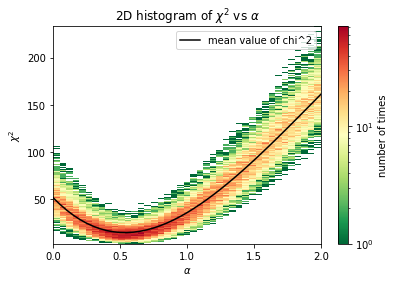

A 0.0 % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum
A 0.1 % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum
A 4.2 % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum
The median minimum is at alpha =  0.55  +  0.09  -  0.1
Energy migration =  True


In [52]:
if niter == 1:
    plt.plot(alphas, chisqs, 'o')
    plt.yscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\chi^2$')
    plt.ylim(0,200)
    plt.show()

    ordering_sigma(alphas, first_bin, last_bin, step, chisqs)

else:
    chisqs_iter = np.array(chisqs_iter)
    alphas_iter = np.array(alphas_iter)
    alphas_iter2 = np.concatenate(alphas_iter)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
    chisqs_iter2 = np.concatenate(chisqs_iter)
    order = np.argsort(alphas_iter[0])


    fig, ax = plt.subplots()
    ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0), color = "black", label="mean value of chi^2")
    h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=[len(alphas_iter[0]),300], norm = colors.LogNorm(), cmap = "RdYlGn_r", label="histogram of chi^2 values")
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\chi^2$')
    ax.legend()
    # ax.set_ylim(0,200)
    # ax.set_xlim(0.5,1.15)
    fig.colorbar(h[3], ax=ax, label="number of times")
    ax.set_title(r"2D histogram of $\chi^2$ vs $\alpha$")
    plt.show()

    sigma_1 = []
    sigma_2 = []
    sigma_3 = []
    s1 = 0
    s2 = 0
    s3 = 0
    for i in range(len(alphas_iter)):
        sigma_1_0 = np.where(chisqs_iter[i] <= 1 + np.min(chisqs_iter[i]))
        sigma_2_0 = np.where(chisqs_iter[i] <= 4 + np.min(chisqs_iter[i]))
        sigma_3_0 = np.where(chisqs_iter[i] <= 9 + np.min(chisqs_iter[i]))
        sigma_1.append(sigma_1_0)
        sigma_2.append(sigma_2_0)
        sigma_3.append(sigma_3_0)
        number = np.where(np.round(alphas, decimals = 4) == 1)
        if number in sigma_1_0[0]: #this number is the position of the alpha=1 inside the alhpas array
            s1 += 1
        if number in sigma_2_0[0]:
            s2 += 1
        if number in sigma_3_0[0]:
            s3 += 1
    # print(sigma_1)
    # print(sigma_2)
    # print(sigma_3)
    print("A {sig} % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum".format( sig = np.round(s1 / niter * 100, decimals = 3)))
    print("A {sig} % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum".format( sig = np.round(s2 / niter * 100, decimals = 3)))
    print("A {sig} % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum".format( sig = np.round(s3 / niter * 100, decimals = 3)))
    # print("The median minimum is at alpha={minimum}".format(minimum = alphas[np.argmin(np.median(chisqs_iter,0))]))

    order = np.argsort(alphas_iter[0])
    interpx = np.arange(first_bin, last_bin, step/5)
    alphas_reord = np.take_along_axis(np.median(alphas_iter, 0), order, axis=0)
    chisqs_repord = np.take_along_axis(np.median(chisqs_iter, 0), order, axis=0)
    f1 = interpolate.interp1d(alphas_reord, chisqs_repord, kind='linear')
    chis_new = f1(interpx)
    sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
    upper_bound_1s = step/5 * np.max(sigma_inter_1s) + first_bin
    lower_bound_1s = step/5 * np.min(sigma_inter_1s) + first_bin
    # print("The 1 sigma upper bound is: ", upper_bound_1s, "and the lower bound is: ", lower_bound_1s)
    print("The median minimum is at alpha = ", np.round(interpx[np.argmin(chis_new)], decimals = 3), " + ", np.round(upper_bound_1s-interpx[np.argmin(chis_new)], decimals = 4), " - ", np.round(interpx[np.argmin(chis_new)] - lower_bound_1s, decimals = 4))
    print("Energy migration = ", Energy_migration)
# chisqs_iter = np.array(chisqs_iter)
# alphas_iter = np.array(alphas_iter)
# alphas_iter2 = np.concatenate(alphas_iter)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
# chisqs_iter2 = np.concatenate(chisqs_iter)
# order = np.argsort(alphas_iter[0])


# fig, ax = plt.subplots()
# ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0), color = "black", label="mean value of chi^2")
# h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=[len(alphas_iter[0]),300], norm = colors.LogNorm(), cmap = "RdYlGn_r", label="histogram of chi^2 values")
# ax.set_xlabel(r'$\alpha$')
# ax.set_ylabel(r'$\chi^2$')
# ax.legend()
# # ax.set_ylim(0,250)
# # ax.set_xlim(0.5,1.15)
# fig.colorbar(h[3], ax=ax, label="number of times")

In [53]:
print(alphas)

[ 1.55000000e+00  1.60000000e+00  1.65000000e+00  1.70000000e+00
  1.75000000e+00  1.80000000e+00  1.85000000e+00  1.90000000e+00
  1.95000000e+00  2.00000000e+00  1.50000000e+00  1.45000000e+00
  1.40000000e+00  1.35000000e+00  1.30000000e+00  1.25000000e+00
  1.20000000e+00  1.15000000e+00  1.10000000e+00  1.05000000e+00
  1.00000000e+00  9.50000000e-01  9.00000000e-01  8.50000000e-01
  8.00000000e-01  7.50000000e-01  7.00000000e-01  6.50000000e-01
  6.00000000e-01  5.50000000e-01  5.00000000e-01  4.50000000e-01
  4.00000000e-01  3.50000000e-01  3.00000000e-01  2.50000000e-01
  2.00000000e-01  1.50000000e-01  1.00000000e-01  5.00000000e-02
 -1.33226763e-15]


In [54]:
alphas_iter[0][np.where(chisqs_iter > 1000)[1]]


array([], dtype=float64)

Now lets find the sigma, 2 sigma and 3 sigma coverages for all those iterations. Also for how many of the iterations the 1, 2 and 3 sigma coverages contain the true alpha value (1).

In [55]:
sigma_1 = []
sigma_2 = []
sigma_3 = []
s1 = 0
s2 = 0
s3 = 0
for i in range(len(alphas_iter)):
    sigma_1_0 = np.where(chisqs_iter[i] <= 1 + np.min(chisqs_iter[i]))
    sigma_2_0 = np.where(chisqs_iter[i] <= 4 + np.min(chisqs_iter[i]))
    sigma_3_0 = np.where(chisqs_iter[i] <= 9 + np.min(chisqs_iter[i]))
    sigma_1.append(sigma_1_0)
    sigma_2.append(sigma_2_0)
    sigma_3.append(sigma_3_0)
    if 20 in sigma_1_0[0]: #this number is the position of the alpha=1 inside the alhpas array
        s1 += 1
    if 20 in sigma_2_0[0]:
        s2 += 1
    if 20 in sigma_3_0[0]:
        s3 += 1
# print(sigma_1)
# print(sigma_2)
# print(sigma_3)
print(s1)
print(s2)
print(s3)

0
1
42


In [56]:
print(alphas_iter[0][20])

0.9999999999999996


In [57]:
######If you want to compute the 1, 2,¡ and 3 sigma intervals for all the iterations uncomment this
interpx = np.arange(0., 1.5, 0.01)
for i in range(len(chisqs_iter)):
    alphas_reord = np.take_along_axis(alphas_iter[i], order, axis=0)
    chisqs_repord = np.take_along_axis(chisqs_iter[i], order, axis=0)
    f1 = interpolate.interp1d(alphas_reord, chisqs_repord, kind='linear')
    chis_new = f1(interpx)
    sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
    upper_bound_1s = 0.01 * np.max(sigma_inter_1s)
    lower_bound_1s = 0.01 * np.min(sigma_inter_1s)
    # print("The 1 sigma upper bound is: ", upper_bound_1s, "and the lower bound is: ", lower_bound_1s)
    print("The minimum is at alpha = ", interpx[np.argmin(chis_new)], " + ", upper_bound_1s-interpx[np.argmin(chis_new)], " - ", interpx[np.argmin(chis_new)] - lower_bound_1s)
    sigma_inter_2s = np.where(chis_new <= 4 + np.min(chis_new))
    upper_bound_2s = 0.01 * np.max(sigma_inter_2s)
    lower_bound_2s = 0.01 * np.min(sigma_inter_2s)
    # print("The 2 sigma upper bound is: ", upper_bound_2s, "and the lower bound is: ", lower_bound_2s)
    # print("The minimum is at alpha = ", interpx[np.argmin(chis_new)], " + ", upper_bound_2s-interpx[np.argmin(chis_new)], " - ", interpx[np.argmin(chis_new)] - lower_bound_2s)
    sigma_inter_3s = np.where(chis_new <= 9 + np.min(chis_new))
    upper_bound_3s = 0.01 * np.max(sigma_inter_3s)
    lower_bound_3s = 0.01 * np.min(sigma_inter_3s)
    # print("The 3 sigma upper bound is: ", upper_bound_3s, "and the lower bound is: ", lower_bound_3s)
    # print("The minimum is at alpha = ", interpx[np.argmin(chis_new)], " + ", upper_bound_3s-interpx[np.argmin(chis_new)], " - ", interpx[np.argmin(chis_new)] - lower_bound_3s)

The minimum is at alpha =  0.5  +  0.07999999999999996  -  0.08999999999999997
The minimum is at alpha =  0.65  +  0.10999999999999999  -  0.07000000000000006
The minimum is at alpha =  0.5  +  0.09999999999999998  -  0.07
The minimum is at alpha =  0.55  +  0.09999999999999998  -  0.09000000000000002
The minimum is at alpha =  0.5  +  0.10999999999999999  -  0.07
The minimum is at alpha =  0.55  +  0.09999999999999998  -  0.07000000000000006
The minimum is at alpha =  0.6  +  0.10999999999999999  -  0.06999999999999995
The minimum is at alpha =  0.55  +  0.06999999999999995  -  0.10000000000000003
The minimum is at alpha =  0.4  +  0.07999999999999996  -  0.09000000000000002
The minimum is at alpha =  0.5  +  0.07999999999999996  -  0.09999999999999998
The minimum is at alpha =  0.45  +  0.07  -  0.10999999999999999
The minimum is at alpha =  0.6  +  0.08000000000000007  -  0.10999999999999999
The minimum is at alpha =  0.65  +  0.07999999999999996  -  0.09999999999999998
The minimum 

Here we will use the last